# Knn Regression

1. Choose K (the number of clusters you want).

2. Initialize K centroids randomly.

3. Repeat until convergence:
   a. Assign each data point to the nearest centroid.
   b. Recalculate the centroids based on the current assignment of data points.
   
4. Return the final K centroids and the corresponding cluster assignments.


### Import Modules and Read Dataset

In [126]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

In [127]:
df = pd.read_csv('../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
# df.head(5)

In [128]:
df = df.astype(int)
# df.head(5)

In [129]:
# Spliting the dataset
# Getting DEP_DELAY for the once only delay 
# any positive values means that it is early departure

df = df[df['DEP_DELAY'] > 0]
df = df.head(1000)

df['DEP_DELAY_shifted'] = df['DEP_DELAY'] - df['DEP_DELAY'].min() + 1
# df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])

print(df['DEP_DELAY'].skew())  # If > 0.5 or < -0.5, transformation is needed
print(df['DEP_DELAY_shifted'].skew())  # If > 0.5 or < -0.5, transformation is needed


4.820893338359548
4.820893338359548


### Transformation Testing

In [130]:
X = df.drop(columns=['DEP_DELAY', 'DEP_DELAY_shifted']) #Dropping DEP_DELAY Log/Sqrt transform cols

# Using Single Log Transformation
y = df['DEP_DELAY_shifted']

y.head(3)

2      40
9       3
14    108
Name: DEP_DELAY_shifted, dtype: int64

### Feature Selection (Post Log Transformation)

In [131]:
X = X.applymap(lambda x: max(x, 0))
X = X.fillna(X.mean())

/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_22373/3256436071.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: max(x, 0))


In [132]:
k_num_features = 15

In [133]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features:")
print(feature_df)

Selected Features:
                 Feature    F-Score
2               DISTANCE  28.007658
1       CRS_ELAPSED_TIME  26.175560
6                sch_dep  20.889370
5               Pressure  20.543771
8   OP_UNIQUE_CARRIER_OO  17.747460
0            DAY_OF_WEEK  12.355943
7   OP_UNIQUE_CARRIER_DL  11.894569
4               Humidity  11.399012
12              DEST_ORF   7.649288
9               DEST_BUF   7.327760
10              DEST_BWI   6.524660
11              DEST_ORD   6.100056
14              DEST_RIC   5.797826
3              Dew Point   5.276309
13              DEST_PWM   5.211619


### Split Training and Test Data 80:20

In [134]:
from sklearn.model_selection import train_test_split 
# X needs to be updated 

X_train, X_test, y_train, y_test = train_test_split(X[feature_df['Feature']], y, test_size = 0.2, random_state = 42)

In [135]:
# X_train

In [136]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### KNN Model

In [137]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=5, metric='manhattan', weights='distance')
# regressor = KNeighborsRegressor(n_neighbors=5, metric='euclidean',  weights='distance')

regressor.fit(X_train, y_train)

KNeighborsRegressor(metric='manhattan', weights='distance')

### Results (MSE, MAE,  Predic vs Acutal Graph)

In [138]:
y_pred_log = regressor.predict(X_test)

# 1 log transformation
y_pred = np.exp(y_pred_log)

# 2 log transformation
# y_pred = np.exp(np.exp(y_pred_log))  

# y_test = np.exp(np.exp(y_test))

In [139]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"R-Squared (R2): {r2:.4f}")


Model Performance Metrics:
Mean Squared Error (MSE): 27571404835846371978794031007537723205831522888973062083723157983872701862149404542330054536779959292505916770814290558976.00
Mean Absolute Error (MAE): 371953523094238113793270930970125134953121529894313457090560.00


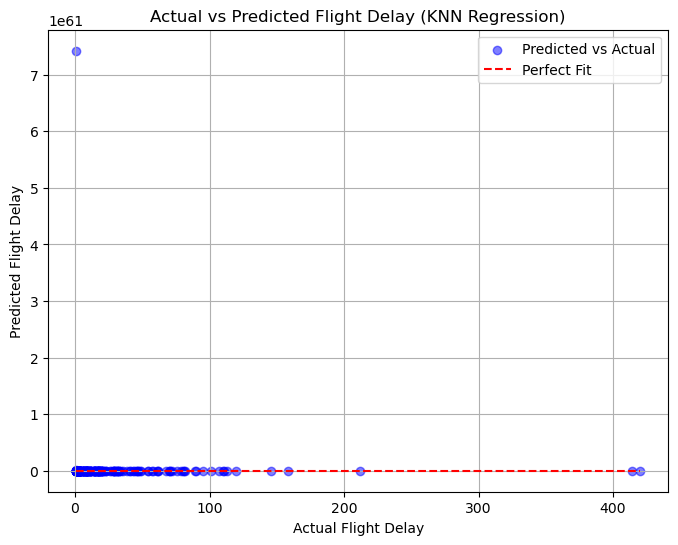

In [140]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Flight Delay")
plt.ylabel("Predicted Flight Delay")
plt.title("Actual vs Predicted Flight Delay (KNN Regression)")
plt.legend()
plt.grid(True)
plt.show()

In [141]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(3, 100, 2)}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)
print("Best k:", grid.best_params_)

Best k: {'n_neighbors': 69}
